In [1]:
!pip install python-box

     |████████████████████████████████| 3.5 MB 24.0 MB/s eta 0:00:01


In [2]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

# 1. 학습 설정

In [3]:
config = {
    'data_path' : "/opt/ml/input/project/model/data" , # 데이터 경로

    'p_dims': [100, 400],
    'dropout_rate' : 0.5,
    'weight_decay' : 0.01,
    'valid_samples' : 2,
    'seed' : 22,
    'anneal_cap' : 0.2,
    'total_anneal_steps' : 200000,
    'save' : 'model.pt',
    
    'lr' : 0.005,
    'batch_size' : 500,
    'num_epochs' : 50,
    'num_workers' : 2,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

# 2. 데이터 전처리

In [4]:
class MakeMatrixDataSet():
    """
    MatrixDataSet 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'G_train.csv'))
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('item')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('user')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['item'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['user'].apply(lambda x : self.user_encoder[x])

        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item in zip(self.df['user_idx'], self.df['item_idx']):
            users[user].append(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            valid = np.random.choice(user_total, size = self.config.valid_samples, replace = False).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def make_matrix(self, user_list, train = True):
        """
        user_item_dict를 바탕으로 행렬 생성
        """
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
        return mat

In [5]:
class AEDataSet(Dataset):
    def __init__(self, num_user):
        self.num_user = num_user
        self.users = [i for i in range(num_user)]

    def __len__(self):
        return self.num_user

    def __getitem__(self, idx): 
        user = self.users[idx]
        return torch.LongTensor([user])

# 3. 모델

## 3-1. Multi-VAE

In [6]:
class MultiVAE(nn.Module):

    def __init__(self, p_dims, dropout_rate = 0.5):
        super(MultiVAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]

        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])

        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

        self.drop = nn.Dropout(dropout_rate)
        self.init_weights()
    
    def forward(self, input, loss = False):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        h = self.decode(z)
        if loss:
            return h, mu, logvar
        else:
            return h
    
    def encode(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = F.tanh(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

## 3-2. Multi-DAE

In [7]:
class MultiDAE(nn.Module):
    
    def __init__(self, p_dims, dropout_rate = 0.5):
        super(MultiDAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        self.dims = self.q_dims + self.p_dims[1:]
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.dims[:-1], self.dims[1:])])
        self.drop = nn.Dropout(dropout_rate)
        
        self.init_weights()
    
    def forward(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i != len(self.layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

# 4. 학습 함수

In [8]:
class LossFunc(nn.Module):

    def __init__(self, loss_type = 'Multinomial', model_type = None):
        super(LossFunc, self).__init__()
        self.loss_type = loss_type
        self.model_type = model_type

    def forward(self, recon_x = None, x = None, mu = None, logvar = None, anneal = None):
        if self.loss_type == 'Gaussian':
            loss = self.Gaussian(recon_x, x)
        elif self.loss_type == 'Logistic':
            loss = self.Logistic(recon_x, x)
        elif self.loss_type == 'Multinomial':
            loss = self.Multinomial(recon_x, x)
        
        if self.model_type == 'VAE':
            KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
            loss = loss + anneal * KLD
        
        return loss

    def Gaussian(self, recon_x, x):
        gaussian = F.mse_loss(recon_x, x)
        return gaussian

    def Logistic(self, recon_x, x):
        logistic = F.binary_cross_entropy(recon_x.sigmoid(), x, reduction='none').sum(1).mean()
        return logistic

    def Multinomial(self, recon_x, x):
        multinomial = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
        return multinomial

In [9]:
def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit

def get_recallk(pred_list, true_list, K):
    a = 0
    for pred in pred_list:
        if pred in true_list:
            a +=1
    recall = a / len(true_list)
    return recall

In [10]:

def train(model, criterion, optimizer, data_loader, make_matrix_data_set, config):
    global update_count
    model.train()
    loss_val = 0
    for users in data_loader:
        mat = make_matrix_data_set.make_matrix(users)
        mat = mat.to(device)

        if criterion.model_type == 'VAE':
            anneal = min(config.anneal_cap, 1. * update_count / config.total_anneal_steps)
            update_count += 1
            recon_mat, mu, logvar = model(mat, loss = True)
            
            optimizer.zero_grad()
            loss = criterion(recon_x = recon_mat, x = mat, mu = mu, logvar = logvar, anneal = anneal)

        else:
            recon_mat = model(mat)
            optimizer.zero_grad()
            loss = criterion(recon_x = recon_mat, x = mat)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()

    loss_val /= len(data_loader)

    return loss_val


In [11]:

def evaluate(model, data_loader, user_train, user_valid, make_matrix_data_set, K = 3):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10
    RECALL_K =0.0 #Recall@10

    with torch.no_grad():
        for users in data_loader:
            mat = make_matrix_data_set.make_matrix(users)
            mat = mat.to(device)

            recon_mat = model(mat)
            recon_mat[mat == 1] = -np.inf
            rec_list = recon_mat.argsort(dim = 1)

            for user, rec in zip(users, rec_list):
                uv = user_valid[user.item()]
                up = rec[-K:].cpu().numpy().tolist()
                NDCG += get_ndcg(pred_list = up, true_list = uv)
                HIT += get_hit(pred_list = up, true_list = uv)
                RECALL_K +=get_recallk(pred_list = up, true_list = uv, K = K )
                
    NDCG /= len(data_loader.dataset)
    HIT /= len(data_loader.dataset)
    RECALL_K /= len(data_loader.dataset)

    return NDCG, HIT, RECALL_K

# 5. 학습

In [12]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()

In [13]:
ae_dataset = AEDataSet(
    num_user = make_matrix_data_set.num_user,
    )

In [14]:
data_loader = DataLoader(
    ae_dataset,
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

## 5-1. Multi-VAE

In [17]:
loss_dict = {}
ndcg_dict = {}
hit_dict = {}
recall_dict = {}

In [18]:
model = MultiVAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Multinomial', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [19]:
best_recall = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
recall_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit, recall= evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    recall_list.append(recall)
    
    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@K: {ndcg:.5f}| HIT@K: {hit:.5f} |Recall@K: {recall:.5f}')


    if recall > best_recall:
        with open(config.save, 'wb') as f:
            torch.save(model, f)
        best_recall = recall

Epoch:   1| Train loss: 66.05422| NDCG@K: 0.04564| HIT@K: 0.03768 |Recall@K: 0.03768
Epoch:   2| Train loss: 58.38110| NDCG@K: 0.07089| HIT@K: 0.05905 |Recall@K: 0.05905
Epoch:   3| Train loss: 53.37576| NDCG@K: 0.07051| HIT@K: 0.05791 |Recall@K: 0.05791
Epoch:   4| Train loss: 50.63732| NDCG@K: 0.07034| HIT@K: 0.05796 |Recall@K: 0.05796
Epoch:   5| Train loss: 48.41486| NDCG@K: 0.07396| HIT@K: 0.06109 |Recall@K: 0.06109
Epoch:   6| Train loss: 47.43527| NDCG@K: 0.07919| HIT@K: 0.06600 |Recall@K: 0.06600
Epoch:   7| Train loss: 46.77139| NDCG@K: 0.07662| HIT@K: 0.06371 |Recall@K: 0.06371
Epoch:   8| Train loss: 46.62782| NDCG@K: 0.08317| HIT@K: 0.06862 |Recall@K: 0.06862
Epoch:   9| Train loss: 46.37007| NDCG@K: 0.08295| HIT@K: 0.06937 |Recall@K: 0.06937
Epoch:  10| Train loss: 46.17319| NDCG@K: 0.08207| HIT@K: 0.06808 |Recall@K: 0.06808
Epoch:  11| Train loss: 46.22875| NDCG@K: 0.08311| HIT@K: 0.06887 |Recall@K: 0.06887
Epoch:  12| Train loss: 45.81652| NDCG@K: 0.08145| HIT@K: 0.06773

In [20]:
loss_dict['Multi-VAE'] = loss_list
ndcg_dict['Multi-VAE'] = ndcg_list
hit_dict['Multi-VAE'] = hit_list
recall_dict['Multi-VAE'] = recall_list

## 5-2. Gaussian-VAE

In [21]:
model = MultiVAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Gaussian', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [22]:
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
recall_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit, recall= evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    recall_list.append(recall)
    
    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@K: {ndcg:.5f}| HIT@K: {hit:.5f} |Recall@K: {recall:.5f}')


    if recall > best_recall:
        with open(config.save, 'wb') as f:
            torch.save(model, f)
        best_recall = recall

Epoch:   1| Train loss: 0.02442| NDCG@K: 0.02588| HIT@K: 0.02112 |Recall@K: 0.02112
Epoch:   2| Train loss: 0.01052| NDCG@K: 0.02420| HIT@K: 0.01954 |Recall@K: 0.01954
Epoch:   3| Train loss: 0.00786| NDCG@K: 0.02359| HIT@K: 0.01929 |Recall@K: 0.01929
Epoch:   4| Train loss: 0.00760| NDCG@K: 0.02190| HIT@K: 0.01706 |Recall@K: 0.01706
Epoch:   5| Train loss: 0.00745| NDCG@K: 0.02205| HIT@K: 0.01810 |Recall@K: 0.01810
Epoch:   6| Train loss: 0.00750| NDCG@K: 0.02160| HIT@K: 0.01780 |Recall@K: 0.01780
Epoch:   7| Train loss: 0.00734| NDCG@K: 0.02198| HIT@K: 0.01765 |Recall@K: 0.01765
Epoch:   8| Train loss: 0.00729| NDCG@K: 0.02372| HIT@K: 0.01944 |Recall@K: 0.01944
Epoch:   9| Train loss: 0.00730| NDCG@K: 0.02305| HIT@K: 0.01820 |Recall@K: 0.01820
Epoch:  10| Train loss: 0.00727| NDCG@K: 0.02332| HIT@K: 0.01904 |Recall@K: 0.01904
Epoch:  11| Train loss: 0.00726| NDCG@K: 0.02114| HIT@K: 0.01820 |Recall@K: 0.01820
Epoch:  12| Train loss: 0.00718| NDCG@K: 0.02200| HIT@K: 0.01740 |Recall@K: 

In [23]:
loss_dict['Gaussian-VAE'] = loss_list
ndcg_dict['Gaussian-VAE'] = ndcg_list
hit_dict['Gaussian-VAE'] = hit_list
recall_dict['Gaussian-VAE'] = recall_list

## 5-3. Logistic-VAE

In [24]:
model = MultiVAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Logistic', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [25]:
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
recall_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit, recall= evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    recall_list.append(recall)
    
    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@K: {ndcg:.5f}| HIT@K: {hit:.5f} |Recall@K: {recall:.5f}')


    if recall > best_recall:
        with open(config.save, 'wb') as f:
            torch.save(model, f)
        best_recall = recall

Epoch:   1| Train loss: 253.20088| NDCG@K: 0.00656| HIT@K: 0.00531 |Recall@K: 0.00531
Epoch:   2| Train loss: 64.33303| NDCG@K: 0.01486| HIT@K: 0.01274 |Recall@K: 0.01274
Epoch:   3| Train loss: 56.42031| NDCG@K: 0.01698| HIT@K: 0.01304 |Recall@K: 0.01304
Epoch:   4| Train loss: 55.71861| NDCG@K: 0.02008| HIT@K: 0.01636 |Recall@K: 0.01636
Epoch:   5| Train loss: 54.45000| NDCG@K: 0.01278| HIT@K: 0.01165 |Recall@K: 0.01165
Epoch:   6| Train loss: 56.48089| NDCG@K: 0.02114| HIT@K: 0.01711 |Recall@K: 0.01711
Epoch:   7| Train loss: 57.17500| NDCG@K: 0.01964| HIT@K: 0.01666 |Recall@K: 0.01666
Epoch:   8| Train loss: 56.34119| NDCG@K: 0.01909| HIT@K: 0.01597 |Recall@K: 0.01597
Epoch:   9| Train loss: 54.17275| NDCG@K: 0.02092| HIT@K: 0.01716 |Recall@K: 0.01716
Epoch:  10| Train loss: 53.96167| NDCG@K: 0.01557| HIT@K: 0.01195 |Recall@K: 0.01195
Epoch:  11| Train loss: 53.80224| NDCG@K: 0.02344| HIT@K: 0.01894 |Recall@K: 0.01894
Epoch:  12| Train loss: 53.59278| NDCG@K: 0.02861| HIT@K: 0.0237

In [26]:
loss_dict['Logistic-VAE'] = loss_list
ndcg_dict['Logistic-VAE'] = ndcg_list
hit_dict['Logistic-VAE'] = hit_list
recall_dict['Logistic-VAE'] = recall_list

## 5-4. Multi-DAE

In [27]:
model = MultiDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Multinomial')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)

In [28]:
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
recall_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit, recall= evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    recall_list.append(recall)
    
    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@K: {ndcg:.5f}| HIT@K: {hit:.5f} |Recall@K: {recall:.5f}')


    if recall > best_recall:
        with open(config.save, 'wb') as f:
            torch.save(model, f)
        best_recall = recall

Epoch:   1| Train loss: 66.04160| NDCG@K: 0.04152| HIT@K: 0.03382 |Recall@K: 0.03382
Epoch:   2| Train loss: 61.10862| NDCG@K: 0.06333| HIT@K: 0.05162 |Recall@K: 0.05162
Epoch:   3| Train loss: 59.60577| NDCG@K: 0.06921| HIT@K: 0.05687 |Recall@K: 0.05687
Epoch:   4| Train loss: 59.43043| NDCG@K: 0.06381| HIT@K: 0.05424 |Recall@K: 0.05424
Epoch:   5| Train loss: 59.32796| NDCG@K: 0.06979| HIT@K: 0.05722 |Recall@K: 0.05722
Epoch:   6| Train loss: 59.25585| NDCG@K: 0.07059| HIT@K: 0.05737 |Recall@K: 0.05737
Epoch:   7| Train loss: 58.76934| NDCG@K: 0.07168| HIT@K: 0.05995 |Recall@K: 0.05995
Epoch:   8| Train loss: 58.62085| NDCG@K: 0.07353| HIT@K: 0.06049 |Recall@K: 0.06049
Epoch:   9| Train loss: 58.27953| NDCG@K: 0.07413| HIT@K: 0.06074 |Recall@K: 0.06074
Epoch:  10| Train loss: 58.63729| NDCG@K: 0.07325| HIT@K: 0.06153 |Recall@K: 0.06153
Epoch:  11| Train loss: 58.20742| NDCG@K: 0.07422| HIT@K: 0.06129 |Recall@K: 0.06129
Epoch:  12| Train loss: 58.67646| NDCG@K: 0.07418| HIT@K: 0.06099

In [29]:
loss_dict['Multi-DAE'] = loss_list
ndcg_dict['Multi-DAE'] = ndcg_list
hit_dict['Multi-DAE'] = hit_list
recall_dict['Multi-DAE'] = recall_list

## 5-5. Gaussian-DAE

In [30]:
model = MultiDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Gaussian')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)

In [31]:
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
recall_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit, recall= evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    recall_list.append(recall)
    
    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@K: {ndcg:.5f}| HIT@K: {hit:.5f} |Recall@K: {recall:.5f}')


    if recall > best_recall:
        with open(config.save, 'wb') as f:
            torch.save(model, f)
        best_recall = recall

Epoch:   1| Train loss: 0.00725| NDCG@K: 0.01947| HIT@K: 0.01537 |Recall@K: 0.01537
Epoch:   2| Train loss: 0.00717| NDCG@K: 0.02308| HIT@K: 0.01795 |Recall@K: 0.01795
Epoch:   3| Train loss: 0.00712| NDCG@K: 0.02079| HIT@K: 0.01671 |Recall@K: 0.01671
Epoch:   4| Train loss: 0.00716| NDCG@K: 0.01697| HIT@K: 0.01423 |Recall@K: 0.01423
Epoch:   5| Train loss: 0.00717| NDCG@K: 0.02131| HIT@K: 0.01631 |Recall@K: 0.01631
Epoch:   6| Train loss: 0.00711| NDCG@K: 0.01880| HIT@K: 0.01611 |Recall@K: 0.01611
Epoch:   7| Train loss: 0.00715| NDCG@K: 0.01623| HIT@K: 0.01324 |Recall@K: 0.01324
Epoch:   8| Train loss: 0.00718| NDCG@K: 0.02134| HIT@K: 0.01740 |Recall@K: 0.01740
Epoch:   9| Train loss: 0.00712| NDCG@K: 0.02323| HIT@K: 0.01909 |Recall@K: 0.01909
Epoch:  10| Train loss: 0.00714| NDCG@K: 0.01961| HIT@K: 0.01542 |Recall@K: 0.01542
Epoch:  11| Train loss: 0.00719| NDCG@K: 0.01789| HIT@K: 0.01497 |Recall@K: 0.01497
Epoch:  12| Train loss: 0.00719| NDCG@K: 0.01863| HIT@K: 0.01458 |Recall@K: 

In [32]:
loss_dict['Gaussian-DAE'] = loss_list
ndcg_dict['Gaussian-DAE'] = ndcg_list
hit_dict['Gaussian-DAE'] = hit_list
recall_dict['Gaussian-DAE'] = recall_list

## 5-6. Logistic-DAE

In [33]:
model = MultiDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Logistic')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)

In [34]:
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
recall_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit, recall= evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    recall_list.append(recall)
    
    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@K: {ndcg:.5f}| HIT@K: {hit:.5f} |Recall@K: {recall:.5f}')


    if recall > best_recall:
        with open(config.save, 'wb') as f:
            torch.save(model, f)
        best_recall = recall

Epoch:   1| Train loss: 224.64374| NDCG@K: 0.01143| HIT@K: 0.00907 |Recall@K: 0.00907
Epoch:   2| Train loss: 62.64483| NDCG@K: 0.01778| HIT@K: 0.01398 |Recall@K: 0.01398
Epoch:   3| Train loss: 55.01888| NDCG@K: 0.01454| HIT@K: 0.01210 |Recall@K: 0.01210
Epoch:   4| Train loss: 54.30253| NDCG@K: 0.01549| HIT@K: 0.01264 |Recall@K: 0.01264
Epoch:   5| Train loss: 53.76815| NDCG@K: 0.01654| HIT@K: 0.01240 |Recall@K: 0.01240
Epoch:   6| Train loss: 54.26970| NDCG@K: 0.02020| HIT@K: 0.01577 |Recall@K: 0.01577
Epoch:   7| Train loss: 53.48844| NDCG@K: 0.01463| HIT@K: 0.01240 |Recall@K: 0.01240
Epoch:   8| Train loss: 52.18686| NDCG@K: 0.02983| HIT@K: 0.02435 |Recall@K: 0.02435
Epoch:   9| Train loss: 50.79548| NDCG@K: 0.03025| HIT@K: 0.02435 |Recall@K: 0.02435
Epoch:  10| Train loss: 50.52550| NDCG@K: 0.03347| HIT@K: 0.02682 |Recall@K: 0.02682
Epoch:  11| Train loss: 50.30061| NDCG@K: 0.02583| HIT@K: 0.02023 |Recall@K: 0.02023
Epoch:  12| Train loss: 50.17890| NDCG@K: 0.03023| HIT@K: 0.0238

In [35]:
loss_dict['Logistic-DAE'] = loss_list
ndcg_dict['Logistic-DAE'] = ndcg_list
hit_dict['Logistic-DAE'] = hit_list
recall_dict['Logistic-DAE'] = recall_list

# 시각화

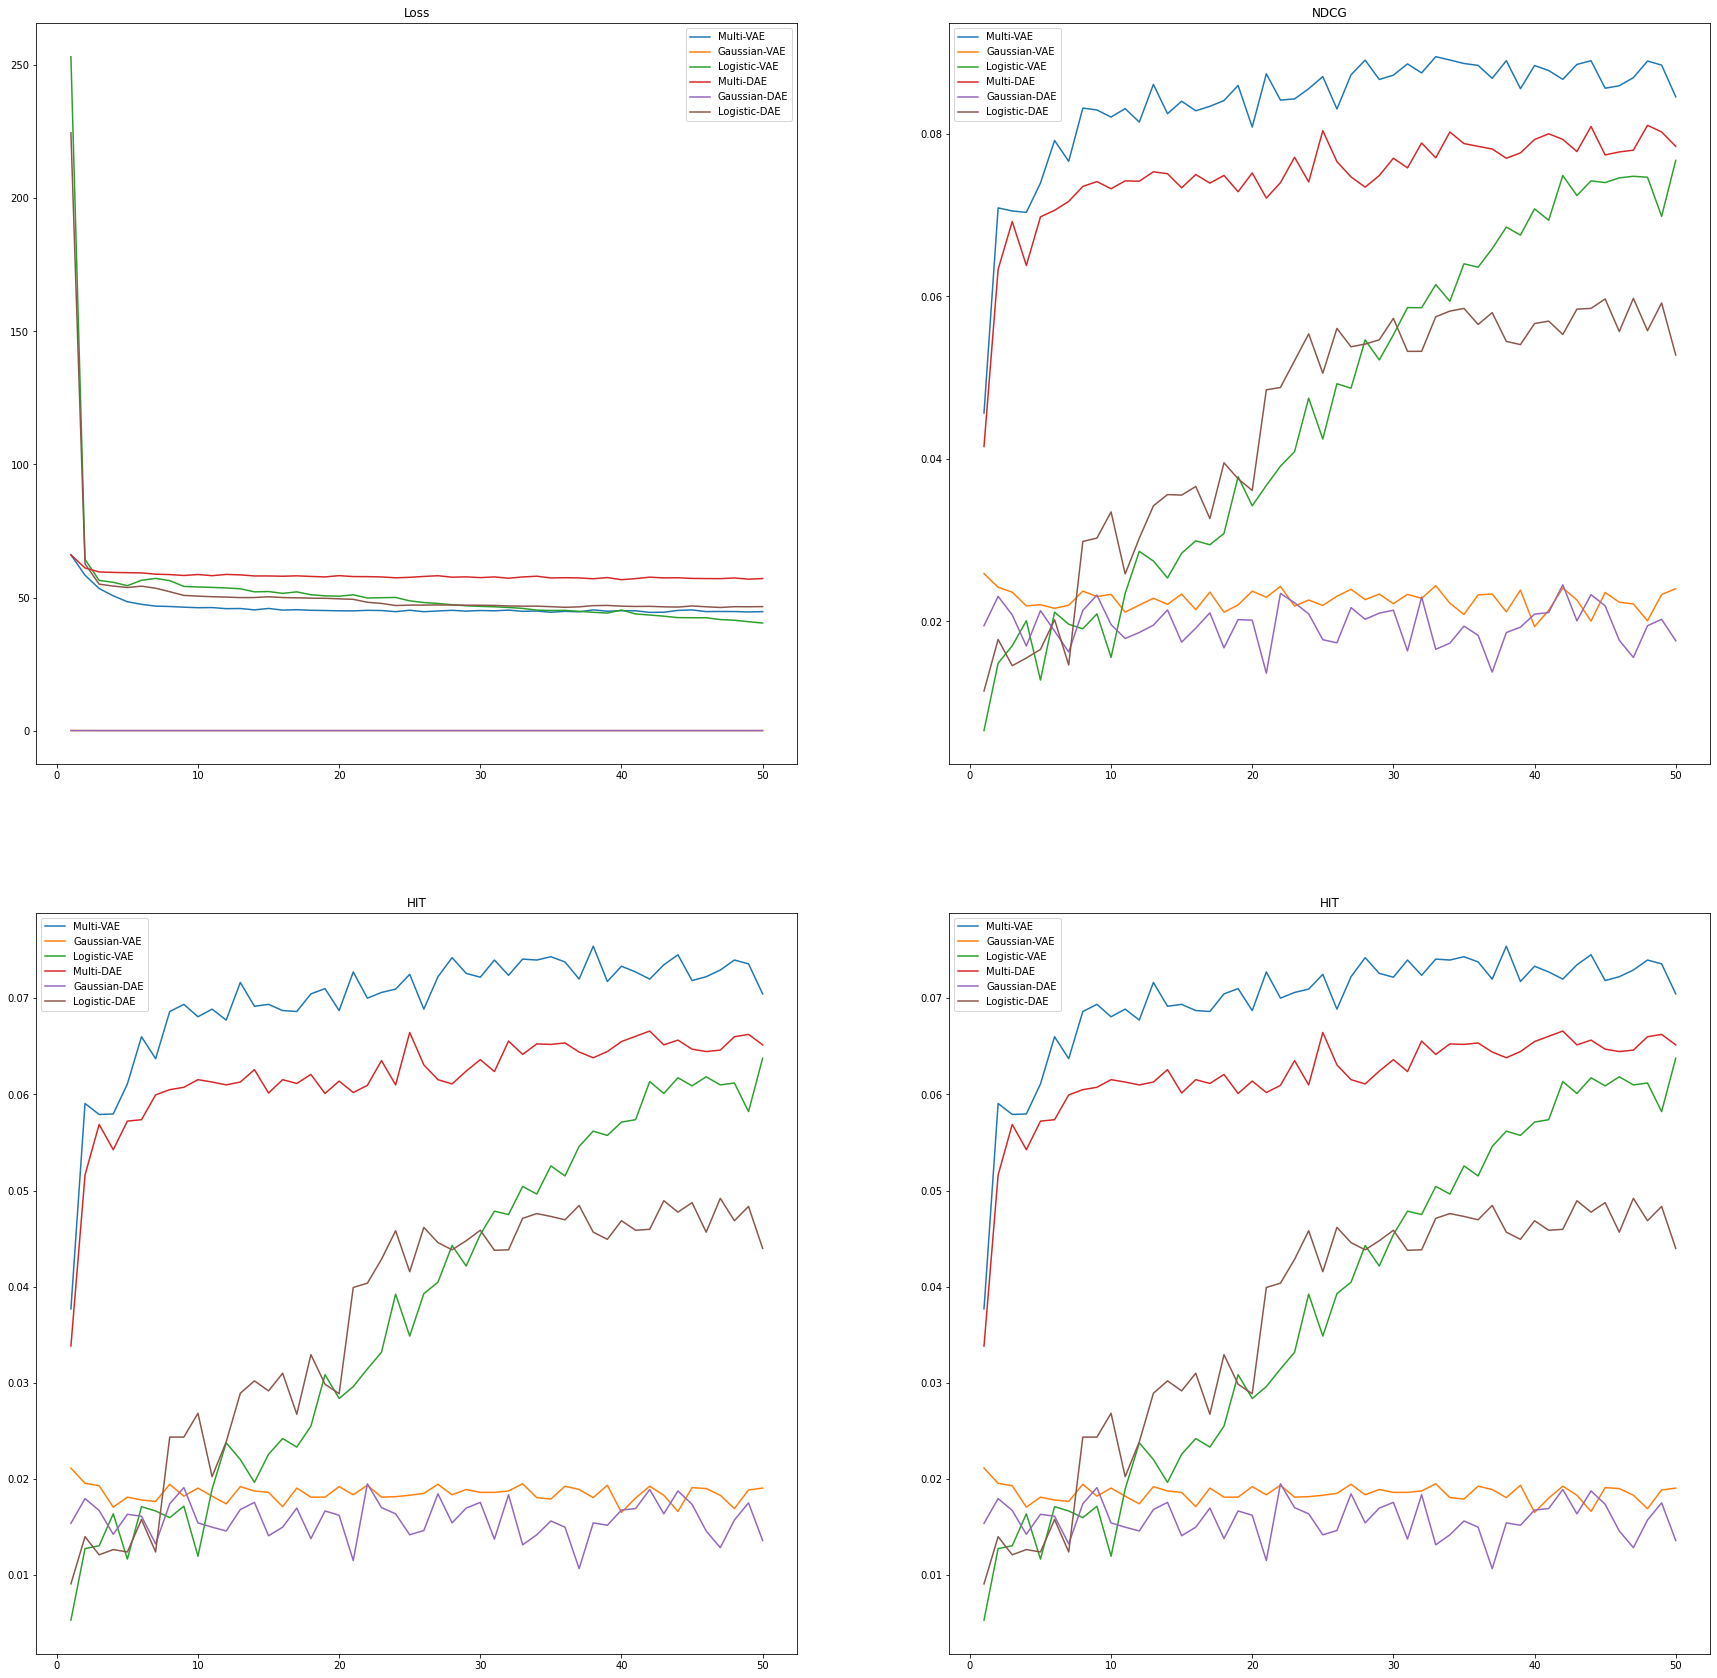

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize = (30, 30))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

for k in loss_dict.keys():
    ax[0].plot(epochs, loss_dict[k], label = k)
ax[0].set_title('Loss')
ax[0].legend()

for k in ndcg_dict.keys():
    ax[1].plot(epochs, ndcg_dict[k], label = k)
ax[1].set_title('NDCG')
ax[1].legend()

for k in hit_dict.keys():
    ax[2].plot(epochs, hit_dict[k], label = k)
ax[2].set_title('HIT')
ax[2].legend()

for k in recall_dict.keys():
    ax[3].plot(epochs, recall_dict[k], label = k)
ax[3].set_title('HIT')
ax[3].legend()

plt.show()